In [59]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Setup the Notebook **

In [60]:
!pip install tensorflow

     
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0

# Import Tensor Flow and necessary libvraries
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from PIL import ImageFile

# data preprocessing and modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

# others
import os, gc, time, pathlib
import tqdm, re, json
import imghdr
seed=24
image_size = (180, 180)

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import functools
import math

from absl import logging
import numpy as np
import six
from six.moves import xrange
import tensorflow.compat.v1 as tf

#import utils
#from condconv import condconv_layers
# pre-trained model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

# sklearn utility functions
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# others
import os, gc, time, pathlib
import tqdm, re, json
import imghdr
import datetime

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Enviromental Variables **

In [61]:

# environmental variables
TRAIN_DATA_PATH = '/content/drive/MyDrive/MMAI_Train/'
VALID_DATA_PATH = '/content/drive/MyDrive/MMAI_valid/'


CLASS_NAMES = sorted(os.listdir(TRAIN_DATA_PATH))
NUM_CLASSES = len(CLASS_NAMES)

In [62]:
# checking availability of GPUs/TPUs
ImageFile.LOAD_TRUNCATED_IMAGES = True
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [63]:
# audit - add timestamp to saved file to avoid overwirting
TIMESTAMP = str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(TIMESTAMP)

20230404-215911


# **2. Data Cleaning **
TensorFlow has some strictness when dealing with image formats. Some times your data set may even run well with, for instance Torch but will generate a format error with Tf. Nonetheless, it is best practice to always carryout preprocessing on the images to ensure a robust, safe and standard model.


In [64]:
def image_quality_check(image_dir):
  '''
  This functions checks whether file formats accepted by Tensorflow ( JPEG, PNG, GIF, BMP), or may be corrupted.
  '''
  from pathlib import Path
  import imghdr

  image_extensions = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']
  img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
  bad_images = []

  for filepath in Path(image_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            bad_images.append(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            bad_images.append(filepath)
  return bad_images
     

In [65]:
def image_quality_check2(image_dir):
  '''
  This function captures corrupted image files (jpg and png) that may missed by first QA function.
  '''
  import os, glob

  # validate directory
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  def is_valid_jpg(jpg_file):
    with open(jpg_file, 'rb') as f:
      f.seek(-2,2)
      buf = f.read()
      return buf == b'\xff\xd9'

  def is_valid_png(png_file):
    with open(png_file, 'rb') as f:
      f.seek(-2,2)
      but = f.read()
      return but == b'\x60\x82'

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.jpg', '.jpeg','.JPG', '.JPEG']:
        if not is_valid_jpg(fpath):
          print(fpath)
          bad_images.append(fpath)
      
      if file[index:] in ['.png', '.PNG']:
        if not is_valid_png(fpath):
          print(fpath)
          bad_images.append(fpath)

  return bad_images

In [66]:
def image_quality_check3(image_dir):
  '''
  This function focuses on identifying corrupted png images that may be missed by the QA1 and QA2.
  '''
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.png', '.PNG']:
        try:
          image = tf.io.read_file(fpath)
          image = tf.image.decode_png(image, channels=3)
        except:
          bad_images.append(fpath)
          print('defective image file: ', fpath)
  return bad_images

In [67]:
# check image quality
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train = image_quality_check(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test = image_quality_check(VALID_DATA_PATH)
     

# check image quality 2
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train2 = image_quality_check2(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test2 = image_quality_check2(VALID_DATA_PATH)
     

# check image quality 3
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train3 = image_quality_check3(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test3 = image_quality_check3(VALID_DATA_PATH)


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs
-------------------- check training set image quality. --------------------
-------------------- check test and validation set image quality. --------------------
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
-------------------- check training set image quality. --------------------


powdery_mildew         : 100%|████████████████████████████████████████| 1004/1004 [00:00<00:00, 1190.17file/s]


-------------------- check test and validation set image quality. --------------------


powdery_mildew         : 100%|██████████████████████████████████████████| 252/252 [00:00<00:00, 1777.89file/s]


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs
-------------------- check training set image quality. --------------------


powdery_mildew         : 100%|██████████████████████████████████████| 1004/1004 [00:00<00:00, 364122.89file/s]


-------------------- check test and validation set image quality. --------------------


powdery_mildew         : 100%|████████████████████████████████████████| 252/252 [00:00<00:00, 529806.82file/s]


In [68]:

move_bad_images = True
bad_images = set(bad_images_train + bad_images_val_test + bad_images_train2 + bad_images_val_test2 + bad_images_train3 + bad_images_val_test3)
bad_images

if move_bad_images:
  for link in bad_images:
    if os.path.exists(link):
      os.remove(str(link))

print('Move {} images with bad quality.'.format(len(bad_images)))
     

# check number of images remained
train_len, test_len = 0, 0
for f in os.listdir(TRAIN_DATA_PATH):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH, f)))
print(train_len);print(test_len)


Move 0 images with bad quality.
25836
6677


In [69]:
del image_quality_check, image_quality_check2, image_quality_check3, bad_images_train, bad_images_val_test, bad_images_train2, bad_images_val_test2, bad_images_train3, bad_images_val_test3
gc.collect()

0

# **STEP#3: **Load Dataset **
We will use high-level Keras preprocessing utilities (such as tf.keras.utils.image_dataset_from_directory) and layers (such as tf.keras.layers.Rescaling) to read a directory of images on disk.

image_dataset_from_directory returns a tf.data.Dataset object, a tuple (images, labels), where images has shape is (batch_size, image_size[0], image_size[1], num_channels).
supported image formats: jpeg, png, bmp, gif
Reference:

tf.keras.utils.image_dataset_from_directory

In [70]:
## Define some parameters for the loader
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH =224
img_height, img_width =224,224
LABEL_MODE = 'categorical'
COLOR_MODE = 'rgb'
batch_size=32

In [71]:

# training set - expect 25,851 (25,835) images
train_ds = keras.utils.image_dataset_from_directory(
        directory=TRAIN_DATA_PATH,
        batch_size = BATCH_SIZE, 
        image_size = (IMG_HEIGHT, IMG_WIDTH), 
        label_mode=LABEL_MODE,
        labels='inferred',
        color_mode=COLOR_MODE,
        shuffle=True,
        seed = seed
        )

Found 25835 files belonging to 11 classes.


In [72]:

# validation and test sets - expect 6684 (6,677) images
val_test_ds = keras.utils.image_dataset_from_directory(
        VALID_DATA_PATH,
        batch_size =batch_size , 
        image_size = (img_height, img_width), 
        label_mode='categorical' ,
        color_mode='rgb' ,
        shuffle=True,
        seed = 123,
        validation_split = 0.5, 
        subset = 'both',
        )

valid_ds = val_test_ds[0]
test_ds = val_test_ds[1]

Found 6677 files belonging to 11 classes.
Using 3339 files for training.
Using 3338 files for validation.


In [73]:
# Save class names and mappings between label_id vs class
CLASS_NAMES = test_ds.class_names
CLASS_NAMES_TF = {k: v for v, k in enumerate(CLASS_NAMES)}
print(CLASS_NAMES)
print(CLASS_NAMES_TF)

['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
{'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato_mosaic_virus': 8, 'healthy': 9, 'powdery_mildew': 10}


In [74]:
# audit - make sure validation and test sets are approximately follow same distributi
assert ((train_ds.class_names == valid_ds.class_names) and (train_ds.class_names == test_ds.class_names)), 'Labels in training, validation, and test do not match'

In [75]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 11)


In [76]:
# check number of batches
print('train dataset size: ' + str(train_ds.cardinality().numpy()))
print('valid dataset size: ' + str(valid_ds.cardinality().numpy()))
print('test dataset size: ' + str(test_ds.cardinality().numpy()))

train dataset size: 808
valid dataset size: 105
test dataset size: 105


Define Utility Functions

In [77]:

def plot_training(hist):
  '''
  This function plots training history. (ie training loss vs validation loss)
  '''
  tr_acc = hist.history['accuracy']
  tr_loss = hist.history['loss']
  val_acc = hist.history['val_accuracy']
  val_loss = hist.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]

  plt.figure(figsize= (20, 8))
  plt.style.use('fivethirtyeight')
  Epochs = [i+1 for i in range(len(tr_acc))]
  loss_label = f'best epoch= {str(index_loss + 1)}'
  acc_label = f'best epoch= {str(index_acc + 1)}'

  plt.subplot(1, 2, 1)
  plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
  plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
  plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
  plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
  plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.tight_layout
  plt.show()

In [78]:

# source: https://github.com/DTrimarchi10/confusion_matrix
def make_confusion_matrix(cf, group_names=None,categories='auto', count=True,percent=False,cbar=True, 
                          xyticks=True,xyplotlabels=True,sum_stats=True,figsize=None,
                          cmap='Blues',title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

### **3. Data Preprocessing **
Data Augmentation 
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [79]:
data_augmentation = keras.Sequential(
    [
      # make model more tolerate to variations in position 
      layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), seed=seed),     
      layers.RandomRotation(0.1, seed = seed),  # randomly rotates images during training
      layers.RandomZoom(0.1, seed = seed),      # randomly flips images during training
      layers.RandomTranslation(height_factor=0.15, width_factor=0.15, seed = seed),  # random geometric translation
     
      # make model more tolerate to different lighting conditions 
      layers.RandomContrast(0.15, seed = seed),       #randomly adjusts contrast during training
      layers.RandomBrightness(factor=0.2, seed=seed)  #randomly increase/decrease brightness during training
    ], name = 'data_augmentation'
)
     

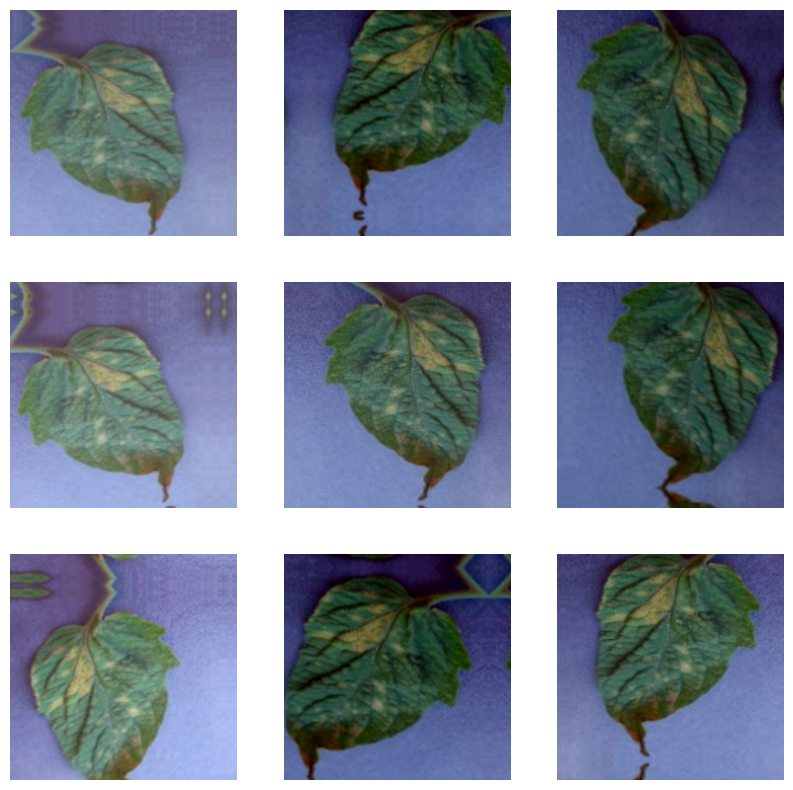

In [80]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# **4. Pre-trained Model EfficientNet**

Convolutional Neural Networks (ConvNets) are commonly developed at a fixed resource budget, and then scaled up for better accuracy if more resources are available. In this paper, we systematically study model scaling and identify that carefully balancing network depth, width, and resolution can lead to better performance. Based on this observation, we propose a new scaling method that uniformly scales all dimensions of depth/width/resolution using a simple yet highly effective compound coefficient. We demonstrate the effectiveness of this method on scaling up MobileNets and ResNet.

To go even further, we use neural architecture search to design a new baseline network and scale it up to obtain a family of models, called EfficientNets, which achieve much better accuracy and efficiency than previous ConvNets. In particular, our EfficientNet-B7 achieves state-of-the-art 84.3% top-1 accuracy on ImageNet, while being 8.4x smaller and 6.1x faster on inference than the best existing ConvNet. Our EfficientNets also transfer well and achieve state-of-the-art accuracy on CIFAR-100 (91.7%), Flowers (98.8%), and 3 other transfer learning datasets, with an order of magnitude fewer parameters. Source code is at this https URL.

In [81]:
# Define the number of classes in your dataset
num_classes = 11


In [82]:
IMG_HEIGHT, IMG_WIDTH = 224, 224   # default image size for Xception is 299x299
BATCH_SIZE = 32
LABEL_MODE = 'categorical'  # labels: one-hot encoded, a float32 tensor of shape (batch_size, num_classes). loss: categorical_crossentropy
COLOR_MODE = 'rgb'
VALID_TEST_RATIO = 0.5
AUTOTUNE = tf.data.AUTOTUNE

In [83]:

params = {
          'RANDOM_STATE': seed,
          'TRAINABLE': False,
          'DENSE_ACTIVATION':'relu',
          'DROPOUT_RATE':0.3,
          'LEARNING_RATE':1e-4,
          'LEARNING_RATE_REDUCE':True,
          'CHECKPOINT':True,
          'EPOCHS':50,
}

In [84]:
# Load the pre-trained EfficientNetB0 model without the top (classifier) layer
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


In [85]:
# Add a new classifier on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
x = Dropout(0.5)(x)  # Add a dropout layer for regularization (optional)
num_classes = 11  # Set the number of output classes for your problem
predictions = Dense(num_classes, activation='softmax')(x)  # Add a dense layer with softmax activation for the final prediction

# Combine the base model and the new classifier into a single model
model = Model(inputs=base_model.input, outputs=predictions)

In [86]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']          
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['rescaling_1[0][0]']            
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['stem_conv_pad[0][0]']          
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                                 
                                                                                                  
 stem_activation (Activation)   (None, 112, 112, 32  0           ['stem_bn[0][0]']                
                                )                                                                 
                                                                                                  
 block1a_dwconv (DepthwiseConv2  (None, 112, 112, 32  288        ['stem_activation[0][0]']        
 D)                             )                                                                 
                                                                                                  
 block1a_bn (BatchNormalization  (None, 112, 112, 32  128        ['block1a_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block1a_activation (Activation  (None, 112, 112, 32  0          ['block1a_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block1a_se_squeeze (GlobalAver  (None, 32)          0           ['block1a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block1a_se_reshape (Reshape)   (None, 1, 1, 32)     0           ['block1a_se_squeeze[0][0]']     
                                                                                                  
 block1a_se_reduce (Conv2D)     (None, 1, 1, 8)      264         ['block1a_se_reshape[0][0]']     
                                                                                                  
 block1a_se_expand (Conv2D)     (None, 1, 1, 32)     288         ['block1a_se_reduce[0][0]']      
                                                                                                  
 block1a_se_excite (Multiply)   (None, 112, 112, 32  0           ['block1a_activation[0][0]',     
                                )                                 'block1a_se_expand[0][0]']      
                                                                                                  
 block1a_project_conv (Conv2D)  (None, 112, 112, 16  512         ['block1a_se_excite[0][0]']      
                                )                                                                 
                                                                                                  
 block1a_project_bn (BatchNorma  (None, 112, 112, 16  64         ['block1a_project_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 block2a_expand_conv (Conv2D)   (None, 112, 112, 96  1536        ['block1a_project_bn[0][0]']     
                                )                                                                 
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 112, 112, 96  384        ['block2a_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block2a_expand_activation (Act  (None, 112, 112, 96  0          ['block2a_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 113, 113, 96  0          ['block2a_expand_activation[0][0]
 g2D)                           )                                ']                               
                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 56, 56, 96)  864         ['block2a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, 56, 56, 96)  384         ['block2a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2a_activation (Activation  (None, 56, 56, 96)  0           ['block2a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2a_se_squeeze (GlobalAver  (None, 96)          0           ['block2a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2a_se_reshape (Reshape)   (None, 1, 1, 96)     0           ['block2a_se_squeeze[0][0]']     
                                                                                                  
 block2a_se_reduce (Conv2D)     (None, 1, 1, 4)      388         ['block2a_se_reshape[0][0]']     
                                                                                                  
 block2a_se_expand (Conv2D)     (None, 1, 1, 96)     480         ['block2a_se_reduce[0][0]']      
                                                                                                  
 block2a_se_excite (Multiply)   (None, 56, 56, 96)   0           ['block2a_activation[0][0]',     
                                                                  'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2b_dwconv (DepthwiseConv2  (None, 56, 56, 144)  1296       ['block2b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2b_bn (BatchNormalization  (None, 56, 56, 144)  576        ['block2b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2b_activation (Activation  (None, 56, 56, 144)  0          ['block2b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2b_se_squeeze (GlobalAver  (None, 144)         0           ['block2b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2b_se_reshape (Reshape)   (None, 1, 1, 144)    0           ['block2b_se_squeeze[0][0]']     
                                                                                                  
 block2b_se_reduce (Conv2D)     (None, 1, 1, 6)      870         ['block2b_se_reshape[0][0]']     
                                                                                                  
 block2b_se_expand (Conv2D)     (None, 1, 1, 144)    1008        ['block2b_se_reduce[0][0]']      
                                                                                                  
 block2b_se_excite (Multiply)   (None, 56, 56, 144)  0           ['block2b_activation[0][0]',     
                                                                  'block2b_se_expand[0][0]']      
                                                                                                  
 block2b_project_conv (Conv2D)  (None, 56, 56, 24)   3456        ['block2b_se_excite[0][0]']      
                                                                                                  
 block2b_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_drop (Dropout)         (None, 56, 56, 24)   0           ['block2b_project_bn[0][0]']     
                                                                                                  
 block2b_add (Add)              (None, 56, 56, 24)   0           ['block2b_drop[0][0]',           
                                                                  'block2a_project_bn[0][0]']     
                                                                                                  
 block3a_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2b_add[0][0]']            
                                                                                                  
 block3a_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block3a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3a_expand_activation (Act  (None, 56, 56, 144)  0          ['block3a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3a_dwconv_pad (ZeroPaddin  (None, 59, 59, 144)  0          ['block3a_expand_activation[0][0]
 g2D)                                                            ']                               
                                                                                                  
 block3a_dwconv (DepthwiseConv2  (None, 28, 28, 144)  3600       ['block3a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block3a_bn (BatchNormalization  (None, 28, 28, 144)  576        ['block3a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3a_activation (Activation  (None, 28, 28, 144)  0          ['block3a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3a_se_squeeze (GlobalAver  (None, 144)         0           ['block3a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3a_se_reshape (Reshape)   (None, 1, 1, 144)    0           ['block3a_se_squeeze[0][0]']     
                                                                                                  
 block3a_se_reduce (Conv2D)     (None, 1, 1, 6)      870         ['block3a_se_reshape[0][0]']     
                                                                                                  
 block3a_se_expand (Conv2D)     (None, 1, 1, 144)    1008        ['block3a_se_reduce[0][0]']      
                                                                                                  
 block3a_se_excite (Multiply)   (None, 28, 28, 144)  0           ['block3a_activation[0][0]',     
                                                                  'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, 28, 28, 40)   5760        ['block3a_se_excite[0][0]']      
                                                                                                  
 block3a_project_bn (BatchNorma  (None, 28, 28, 40)  160         ['block3a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, 28, 28, 240)  9600        ['block3a_project_bn[0][0]']     
                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_activation (Activation  (None, 28, 28, 240)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_se_excite (Multiply)   (None, 28, 28, 240)  0           ['block3b_activation[0][0]',     
                                                                  'block3b_se_expand[0][0]']      
                                                                                                  
 block3b_project_conv (Conv2D)  (None, 28, 28, 40)   9600        ['block3b_se_excite[0][0]']      
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 40)  160         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_drop (Dropout)         (None, 28, 28, 40)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_add (Add)              (None, 28, 28, 40)   0           ['block3b_drop[0][0]',           
                                                                  'block3a_project_bn[0][0]']     
                                                                                                  
 block4a_expand_conv (Conv2D)   (None, 28, 28, 240)  9600        ['block3b_add[0][0]']            
                                                                                                  
 block4a_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block4a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4a_expand_activation (Act  (None, 28, 28, 240)  0          ['block4a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4a_dwconv_pad (ZeroPaddin  (None, 29, 29, 240)  0          ['block4a_expand_activation[0][0]
 g2D)                                                            ']                               
                                                                                                  
 block4a_dwconv (DepthwiseConv2  (None, 14, 14, 240)  2160       ['block4a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block4a_bn (BatchNormalization  (None, 14, 14, 240)  960        ['block4a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4a_activation (Activation  (None, 14, 14, 240)  0          ['block4a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 240)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 14, 14, 240)  0           ['block4a_activation[0][0]',     
                                                                  'block4a_se_expand[0][0]']      
                                                                                                  
 block4a_project_conv (Conv2D)  (None, 14, 14, 80)   19200       ['block4a_se_excite[0][0]']      
                                                                                                  
 block4a_project_bn (BatchNorma  (None, 14, 14, 80)  320         ['block4a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, 14, 14, 480)  38400       ['block4a_project_bn[0][0]']     
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, 14, 14, 480)  1920       ['block4b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4b_expand_activation (Act  (None, 14, 14, 480)  0          ['block4b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block4b_se_reshape[0][0]']     
                                                                                                  
 block4b_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block4b_se_reduce[0][0]']      
                                                                                                  
 block4b_se_excite (Multiply)   (None, 14, 14, 480)  0           ['block4b_activation[0][0]',     
                                                                  'block4b_se_expand[0][0]']      
                                                                                                  
 block4b_project_conv (Conv2D)  (None, 14, 14, 80)   38400       ['block4b_se_excite[0][0]']      
                                                                                                  
 block4b_project_bn (BatchNorma  (None, 14, 14, 80)  320         ['block4b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_drop (Dropout)         (None, 14, 14, 80)   0           ['block4b_project_bn[0][0]']     
                                                                                                  
 block4b_add (Add)              (None, 14, 14, 80)   0           ['block4b_drop[0][0]',           
                                                                  'block4a_project_bn[0][0]']     
                                                                                                  
 block4c_expand_conv (Conv2D)   (None, 14, 14, 480)  38400       ['block4b_add[0][0]']            
                                                                                                  
 block4c_expand_bn (BatchNormal  (None, 14, 14, 480)  1920       ['block4c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4c_expand_activation (Act  (None, 14, 14, 480)  0          ['block4c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4c_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4c_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4c_activation (Activation  (None, 14, 14, 480)  0          ['block4c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4c_se_squeeze (GlobalAver  (None, 480)         0           ['block4c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4c_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4c_se_squeeze[0][0]']     
                                                                                                  
 block4c_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block4c_se_reshape[0][0]']     
                                                                                                  
 block4c_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, 14, 14, 480)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 14, 14, 80)   38400       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 14, 14, 80)  320         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 14, 14, 80)   0           ['block4c_project_bn[0][0]']     
                                                                                                  
 block4c_add (Add)              (None, 14, 14, 80)   0           ['block4c_drop[0][0]',           
                                                                  'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 14, 14, 480)  38400       ['block4c_add[0][0]']            
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, 14, 14, 480)  1920       ['block5a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 14, 14, 480)  0          ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5a_dwconv (DepthwiseConv2  (None, 14, 14, 480)  12000      ['block5a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5a_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block5a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_se_excite (Multiply)   (None, 14, 14, 480)  0           ['block5a_activation[0][0]',     
                                                                  'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_project_conv (Conv2D)  (None, 14, 14, 112)  53760       ['block5a_se_excite[0][0]']      
                                                                                                  
 block5a_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_expand_activation (Act  (None, 14, 14, 672)  0          ['block5b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5b_dwconv (DepthwiseConv2  (None, 14, 14, 672)  16800      ['block5b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, 14, 14, 672)  2688       ['block5b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5b_activation (Activation  (None, 14, 14, 672)  0          ['block5b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5b_se_squeeze (GlobalAver  (None, 672)         0           ['block5b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5b_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5b_se_squeeze[0][0]']     
                                                                                                  
 block5b_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5b_se_reshape[0][0]']     
                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5b_se_reduce[0][0]']      
                                                                                                  
 block5b_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5b_activation[0][0]',     
                                                                  'block5b_se_expand[0][0]']      
                                                                                                  
 block5b_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5b_se_excite[0][0]']      
                                                                                                  
 block5b_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_drop (Dropout)         (None, 14, 14, 112)  0           ['block5b_project_bn[0][0]']     
                                                                                                  
 block5b_add (Add)              (None, 14, 14, 112)  0           ['block5b_drop[0][0]',           
                                                                  'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5b_add[0][0]']            
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block5c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5c_expand_activation (Act  (None, 14, 14, 672)  0          ['block5c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, 14, 14, 672)  16800      ['block5c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, 14, 14, 672)  2688       ['block5c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5c_activation (Activation  (None, 14, 14, 672)  0          ['block5c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5c_se_squeeze (GlobalAver  (None, 672)         0           ['block5c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5c_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5c_se_squeeze[0][0]']     
                                                                                                  
 block5c_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5c_se_reshape[0][0]']     
                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_add (Add)              (None, 14, 14, 112)  0           ['block5c_drop[0][0]',           
                                                                  'block5b_add[0][0]']            
                                                                                                  
 block6a_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5c_add[0][0]']            
                                                                                                  
 block6a_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block6a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6a_expand_activation (Act  (None, 14, 14, 672)  0          ['block6a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6a_dwconv_pad (ZeroPaddin  (None, 17, 17, 672)  0          ['block6a_expand_activation[0][0]
 g2D)                                                            ']                               
                                                                                                  
 block6a_dwconv (DepthwiseConv2  (None, 7, 7, 672)   16800       ['block6a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block6a_bn (BatchNormalization  (None, 7, 7, 672)   2688        ['block6a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6a_activation (Activation  (None, 7, 7, 672)   0           ['block6a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6a_se_squeeze (GlobalAver  (None, 672)         0           ['block6a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_se_excite (Multiply)   (None, 7, 7, 672)    0           ['block6a_activation[0][0]',     
                                                                  'block6a_se_expand[0][0]']      
                                                                                                  
 block6a_project_conv (Conv2D)  (None, 7, 7, 192)    129024      ['block6a_se_excite[0][0]']      
                                                                                                  
 block6a_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6a_project_bn[0][0]']     
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6b_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  28800       ['block6b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6b_activation (Activation  (None, 7, 7, 1152)  0           ['block6b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 1152)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6b_se_reshape[0][0]']     
                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6b_activation[0][0]',     
                                                                  'block6b_se_expand[0][0]']      
                                                                                                  
 block6b_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6b_se_excite[0][0]']      
                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6c_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6c_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  28800       ['block6c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6c_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6c_activation (Activation  (None, 7, 7, 1152)  0           ['block6c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6c_se_squeeze (GlobalAver  (None, 1152)        0           ['block6c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6c_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6c_se_squeeze[0][0]']     
                                                                                                  
 block6c_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6c_se_reshape[0][0]']     
                                                                                                  
 block6c_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6c_se_reduce[0][0]']      
                                                                                                  
 block6c_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6c_activation[0][0]',     
                                                                  'block6c_se_expand[0][0]']      
                                                                                                  
 block6c_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6c_se_excite[0][0]']      
                                                                                                  
 block6c_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6c_drop (Dropout)         (None, 7, 7, 192)    0           ['block6c_project_bn[0][0]']     
                                                                                                  
 block6c_add (Add)              (None, 7, 7, 192)    0           ['block6c_drop[0][0]',           
                                                                  'block6b_add[0][0]']            
                                                                                                  
 block6d_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6c_add[0][0]']            
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6d_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6d_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  28800       ['block6d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6d_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 7, 7, 1152)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1152)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6d_se_reshape[0][0]']     
                                                                                                  
 block6d_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6d_se_reduce[0][0]']      
                                                                                                  
 block6d_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6d_activation[0][0]',     
                                                                  'block6d_se_expand[0][0]']      
                                                                                                  
 block6d_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6d_se_excite[0][0]']      
                                                                                                  
 block6d_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6d_drop (Dropout)         (None, 7, 7, 192)    0           ['block6d_project_bn[0][0]']     
                                                                                                  
 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  10368       ['block7a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block7a_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block7a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block7a_activation (Activation  (None, 7, 7, 1152)  0           ['block7a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block7a_se_squeeze (GlobalAver  (None, 1152)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block7a_activation[0][0]',     
                                                                  'block7a_se_expand[0][0]']      
                                                                                                  
 block7a_project_conv (Conv2D)  (None, 7, 7, 320)    368640      ['block7a_se_excite[0][0]']      
                                                                                                  
 block7a_project_bn (BatchNorma  (None, 7, 7, 320)   1280        ['block7a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 top_conv (Conv2D)              (None, 7, 7, 1280)   409600      ['block7a_project_bn[0][0]']     
                                                                                                  
 top_bn (BatchNormalization)    (None, 7, 7, 1280)   5120        ['top_conv[0][0]']               
                                                                                                  
 top_activation (Activation)    (None, 7, 7, 1280)   0           ['top_bn[0][0]']                 
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['top_activation[0][0]']         
 alAveragePooling2D)                                                                              
                                                                                                  
 dropout (Dropout)              (None, 1280)         0           ['global_average_pooling2d[0][0]'
                                                                 ]                                
                                                                                                  
 dense (Dense)                  (None, 11)           14091       ['dropout[0][0]']                
                                                                                                  
==================================================================================================
Total params: 4,063,662
Trainable params: 4,021,639
Non-trainable params: 42,023
__________________________________________________________________________________________________


Traing Model 

In [87]:

# early stopping 
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min',
    restore_best_weights=True,
    patience=7, 
    verbose=1
)
     

In [88]:
# check point - save best model
model_name = 'Efficientnet'
model_type = 'feat-extract'
parent_folder = '/content/drive/MyDrive/deeplearning/model/'

assert os.path.exists(parent_folder), "Error: directory does not exist"
model_fpath = '/content/drive/MyDrive/deeplearning/model/'+ model_name +'.hdf5'
print(model_fpath)

/content/drive/MyDrive/deeplearning/model/xception_feat-extract_20230404-215911.hdf5


In [89]:

check_point = ModelCheckpoint(filepath=model_fpath,
                              monitor='val_loss',
                              mode='min',
                              save_best_only=True,
                              save_weights_only=False
                              )

In [90]:

# Learning Rate Annealer - Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
lr_reducer = ReduceLROnPlateau(monitor='val_loss', 
                               factor=.5, 
                               patience=3, 
                               min_lr=1e-5, 
                               verbose = 1)

In [91]:

callbacks = [early_stopping]

if params['CHECKPOINT']:
  callbacks.append(check_point)
if params['LEARNING_RATE_REDUCE']:
  callbacks.append(lr_reducer)

callbacks

In [92]:
# Define the number of classes in your dataset
num_classes = 11
predictions = Dense(num_classes, activation='softmax')(x)  # Add a dense layer with softmax activation for the final prediction

In [93]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=params['EPOCHS'],
    callbacks=[early_stopping]
)

Epoch 1/50
808/808 [==============================] - 131s 99ms/step - loss: 0.3711 - accuracy: 0.8775 - val_loss: 0.1927 - val_accuracy: 0.9362
Epoch 2/50
808/808 [==============================] - 66s 81ms/step - loss: 0.1660 - accuracy: 0.9460 - val_loss: 0.3324 - val_accuracy: 0.9087
Epoch 3/50
808/808 [==============================] - 66s 81ms/step - loss: 0.1235 - accuracy: 0.9594 - val_loss: 0.1703 - val_accuracy: 0.9506
Epoch 4/50
808/808 [==============================] - 66s 82ms/step - loss: 0.1053 - accuracy: 0.9641 - val_loss: 0.2036 - val_accuracy: 0.9437
Epoch 5/50
808/808 [==============================] - 66s 81ms/step - loss: 0.0799 - accuracy: 0.9740 - val_loss: 0.3321 - val_accuracy: 0.9221
Epoch 6/50
808/808 [==============================] - 66s 81ms/step - loss: 0.0712 - accuracy: 0.9773 - val_loss: 0.1006 - val_accuracy: 0.9689
Epoch 7/50
808/808 [==============================] - 66s 81ms/step - loss: 0.0699 - accuracy: 0.9769 - val_loss: 0.1901 - val_accuracy

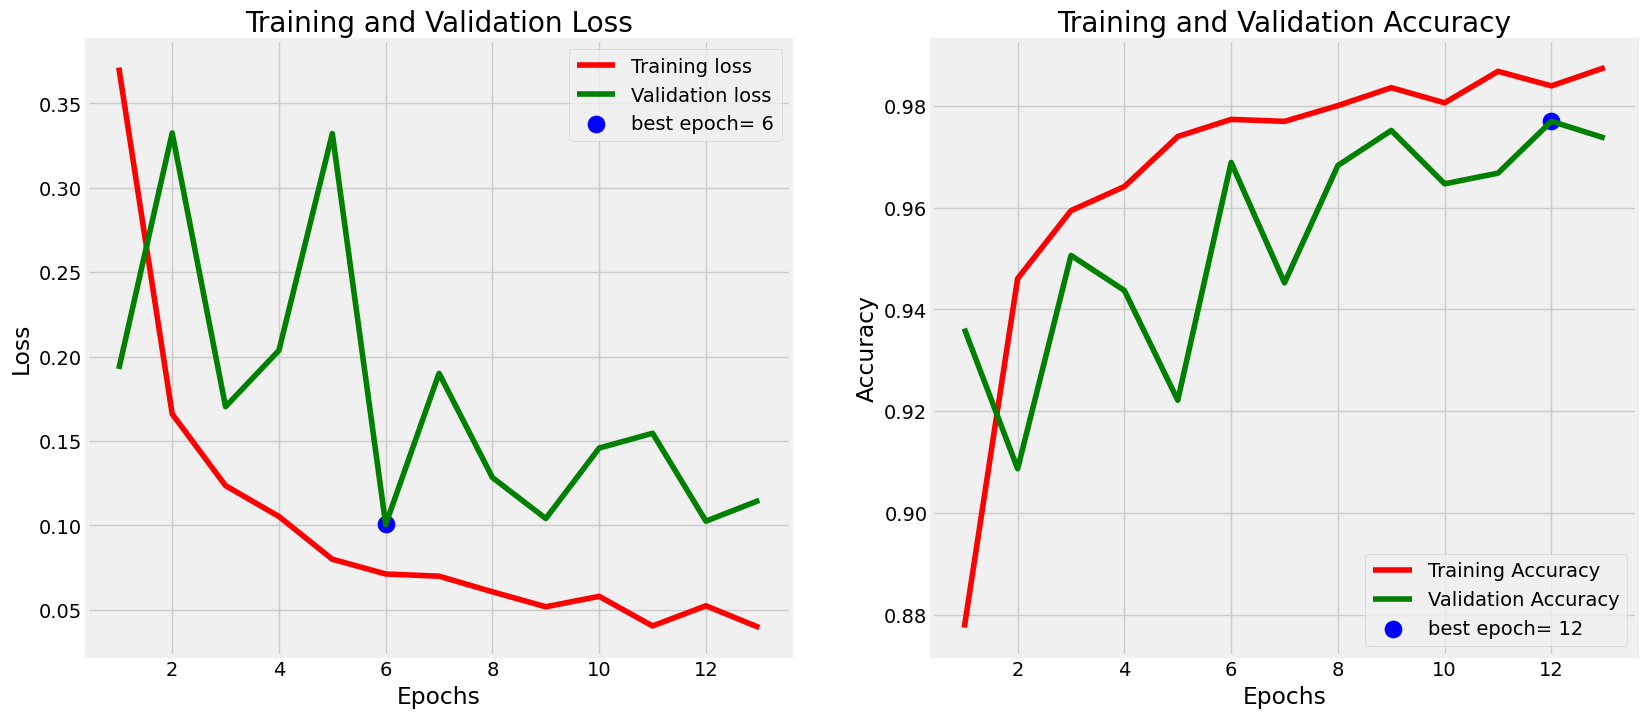

In [94]:
plot_training(history)

In [95]:
import h5py

filename = '/content/drive/MyDrive/deeplearning/model/xception_feat-extract_20230401-123525.hdf5'

with h5py.File(filename, 'r') as f:
    print("Keys: %s" % f.keys())
    layer_names = list(f.keys())
    for layer_name in layer_names:
        print(f"{layer_name}: {list(f[layer_name].keys())}")

Keys: <KeysViewHDF5 []>


In [96]:

test_loss, test_accuracy = model.evaluate(test_ds)

print("test loss: {} and test accuracy: {}".format(test_loss, test_accuracy))
     

105/105 [==============================] - 21s 199ms/step - loss: 0.0878 - accuracy: 0.9766
test loss: 0.0877678245306015 and test accuracy: 0.9766327142715454


In [97]:
train_loss, train_accuracy = model.evaluate(train_ds)
valid_loss, valid_accuracy = model.evaluate(valid_ds)

print("training loss: {} and training accuracy: {}".format(train_loss, train_accuracy))
print("validation loss: {} and validation accuracy: {}".format(valid_loss, valid_accuracy))

105/105 [==============================] - 3s 29ms/step - loss: 0.1006 - accuracy: 0.9689
training loss: 0.03356340900063515 and training accuracy: 0.9893168210983276
validation loss: 0.10056091099977493 and validation accuracy: 0.9688529372215271


In [98]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_ds:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

1/1 [==============================] - 1s 1s/step


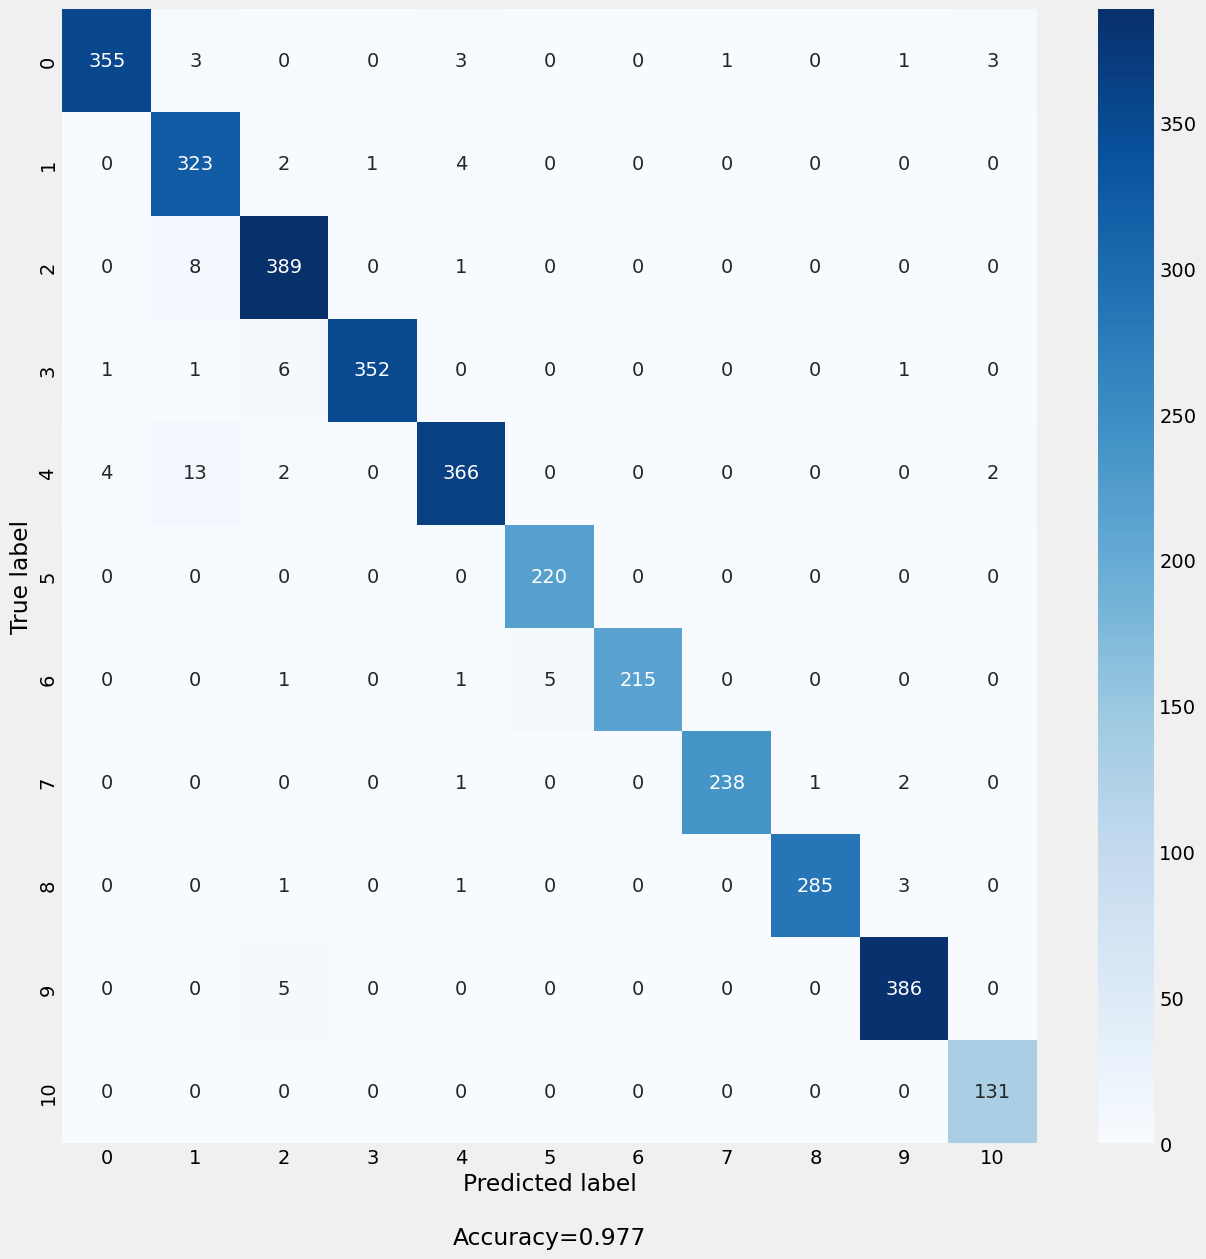

In [99]:
cf = confusion_matrix(y_true, y_pred)
make_confusion_matrix(cf, CLASS_NAMES ,figsize=(14,14))

Follow-up: Load Best Model Back and Generate Additional Performance Metrics
classification report, includes precision, recall, f1-score by classes

confusion matrix with target names

To reuse saved model, we need to complete required data prepration steps:

load images from directory and conduct train/validation/test split to create tf.data.dataset
conduct data preprocessing either separately or inside of model pipeline (depends on data preprocessing configuration)
Load Best Model

In [100]:
from keras.models import load_model

In [103]:
model_fpath = '/content/drive/MyDrive/deeplearning/model/xception_feat-extract_20230401-123525.hdf5'



In [106]:

test_loss, test_accuracy = model.evaluate(test_ds)
print("test loss: {} and test accuracy: {}".format(test_loss, test_accuracy))

105/105 [==============================] - 3s 32ms/step - loss: 0.0878 - accuracy: 0.9766
test loss: 0.0877678245306015 and test accuracy: 0.9766327142715454


# Generate **Report** **bold text**

In [107]:

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [108]:

def plt_confusion_mtrx(y_true, y_pred, target_names):
      # classification report
      print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

      # plot confusion matrix
      conf_mtx = confusion_matrix(y_true, y_pred)
      accuracy = np.trace(conf_mtx) / float(np.sum(conf_mtx))
      disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtx, display_labels=target_names)
      fig, ax = plt.subplots(figsize=(10,10)) 

      # beautify the plot
      disp.plot(cmap='Blues',ax=ax)
      plt.grid(False)
      ax.set_title ('Confusion Matrix for Tomato Leaf Disease - Without Normalization')
      ax.set_xlabel('Predicted labels' + "\n\nAccuracy={:0.3f}".format(accuracy))
      ax.set_ylabel('True label')
      ax.set_xticklabels(target_names, rotation=90)

      plt.show()

In [109]:

target_names = ['Bacterial_spot','Early_blight','Late_blight','Leaf_Mold','Septoria_leaf_spot','Spider_mites Two-spotted_spider_mite',
                'Target_Spot','Tomato_Yellow_Leaf_Curl_Virus','Tomato_mosaic_virus','healthy','powdery_mildew']

In [110]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_ds:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

1/1 [==============================] - 0s 27ms/step


                                      precision    recall  f1-score   support

                      Bacterial_spot      0.986     0.970     0.978       366
                        Early_blight      0.928     0.979     0.953       330
                         Late_blight      0.958     0.977     0.968       398
                           Leaf_Mold      0.997     0.975     0.986       361
                  Septoria_leaf_spot      0.971     0.946     0.958       387
Spider_mites Two-spotted_spider_mite      0.978     1.000     0.989       220
                         Target_Spot      1.000     0.968     0.984       222
       Tomato_Yellow_Leaf_Curl_Virus      0.996     0.983     0.990       242
                 Tomato_mosaic_virus      0.997     0.983     0.990       290
                             healthy      0.982     0.987     0.985       391
                      powdery_mildew      0.963     1.000     0.981       131

                            accuracy                          

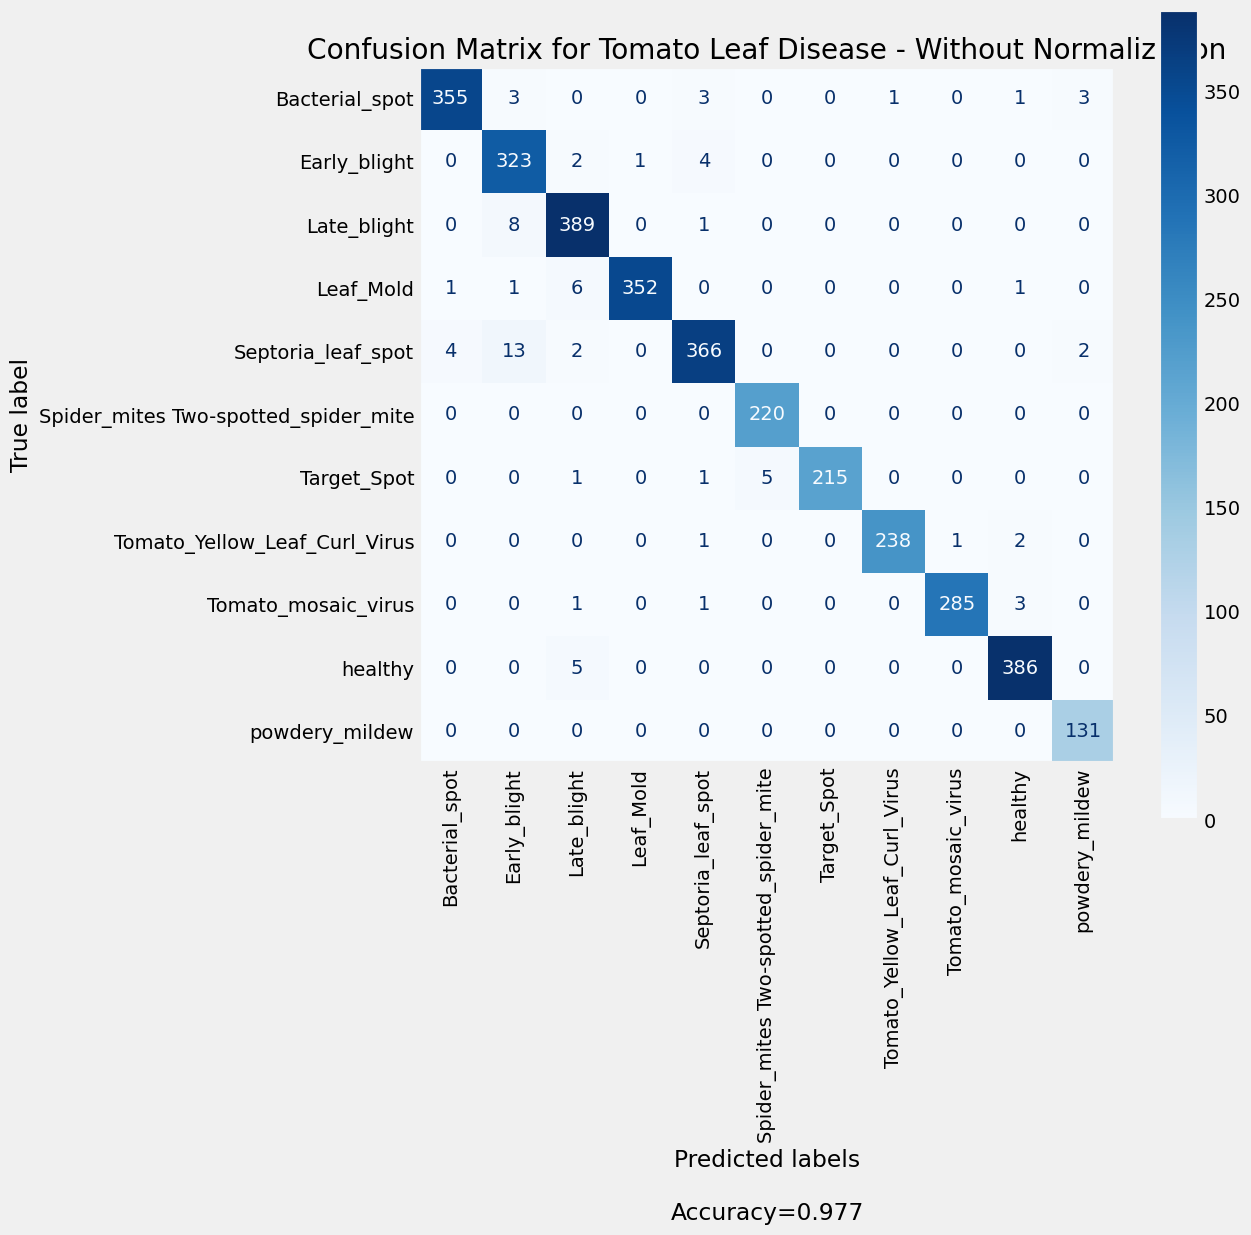

In [111]:
plt_confusion_mtrx(y_true, y_pred, target_names)